# Grover's algorithm 

#### *Author*: Júlia Barberà, 29th April of 2022

This notebook presents a demonstration of how Grover's algorithm performs when we want to find an element from a list. It also shows how the results converge as $\sqrt(N)$ with $N = 2^{nqubits}$ in comparison with the classical method used for unsorted data search.
 <br>
 
We use 3 qubits to show the algorithm's performance and the results for each section. However, this program is valid for any number of $nqubits$. 

The code is written using Qibo language and qibojit, qibotf, tensorflow, numpy simulator as a default backend.

__Table of contents:__
1. Defining functions
    1. Binary to decimal function
    1. MCZ gate 
    1. Grover's Oracle 
    1. Diffusion operator 


2. Main code: Grover's algorithm
    1. Grover's algorithm for 5 qubits
    1. Plots
    
    
3. Scan with n=2,...,8 qubits
    1. Quantum algorithm (Grover's)
    1. Classical algorithm
    1. Plot comparison

In [2]:
# Import all libraries that I will use
import numpy as np
from qibo.models import Circuit
from qibo import gates
from qibo import callbacks
import matplotlib.pyplot as plt

## Functions


Firstly, we introduce some functions that we will use in the main code. They will be universal for any state we want to find. 

### Binary to decimal and vice versa functions

There are two methods to convert a binary number into a decimal number and we will use the positional notation to convert them. The weight of the positions will be $2^0, 2^1, 2^2, 2^3,...$ so the first thing we need to do is count the number of digits (positions) the binary number has. Then, these weights will be multiplying the digit corresponding to its binary number (0 or 1). Finally, we will sum up everything. 

Let's assume our binary number is $10110$:


<br>

<center> decimal number $= 1 \cdot 2^4 + 0 \cdot 2^3 + 1 \cdot 2^2 + 1 \cdot 2^1 + 0 \cdot 2^0 = 22 $ </center>


<br>

The binary state will be the one we want to find, and we will use this function to transform the state into a decimal number to find the inverting matrix classically. 

In [3]:
def binary_to_decimal(binary_number):
    decimal_number = 0 #Initialize the number 

    for position, string_digit in enumerate(binary_number[::-1]):
        decimal_number += int(string_digit) * 2 ** position

    return decimal_number


The following function generates a list of the binary number digits of dimension $nqubits$. 

In [4]:
def bin_list(dec,nqubits): 
    binary = format(dec,'0{}b'.format(nqubits))
    return list(map(int, str(binary)))

### Multi-controlled Z gate 

The CZ gate is used to invert the phase of the state $|11...1\rangle$. To ease the calculation we can express the CZ gate in terms of other quantum logic gates: $Z = H X H$. 
The MCZ of the circuit will have the following transformation: 

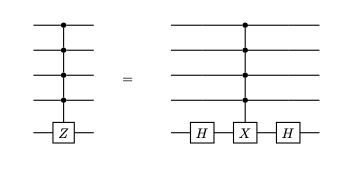

This gate will be used for the Oracle and the Diffusion operator. 

In [5]:
def MCZ(q0,nqubits): # defining multi-controlled Z function 
    c.add(gates.H(nqubits-1))
    c.add(gates.X(nqubits-1).controlled_by(*range(0,nqubits-1)))
    c.add(gates.H(nqubits-1))
    return c 

### Grover's oracle: $U_w$

The Grover's oracle generates a reflection of the state we want to find. Imagine we have the following superposition ($nqubits = 2$): $|s\rangle = \frac{1}{{2}} (|00 \rangle +|01 \rangle +|10 \rangle +|11 \rangle) $ and we want to find the state $|10 \rangle$. When we apply the oracle to the initial state it will turn into: <center> $U_w|s\rangle = \frac{1}{{2}} (|00 \rangle +|01 \rangle -|10 \rangle +|11 \rangle) $ 
    
We can recognize that the CZ quantum gate is the one that performs this operation. But firstly, we will create a classical diagonal matrix filled with ones on the diagonal except at the position that corresponds to the state we want to find, which will have the value -1 in order to flip the state.  

In [6]:
def oracle_matrix(nqubits,state):
    
    inv_matrix = np.zeros( (2**nqubits, 2**nqubits) ) 

    for i in range(0,2**nqubits):
        for j in range(0,2**nqubits):
            if i == j:
                if i == state : 
                    inv_matrix[i][j] = -1 #add a -1 in order to flip the state
                else:
                    inv_matrix[i][j] = 1 

    return c.add(gates.Unitary(inv_matrix,*range(0,nqubits)))
    

However, we need to construct Grover's oracle with quantum gates. 

As it has been shown, the matrix that we need has de following shape diag{1,1,1,1,-1,1,1,1,1} if we want to find, for example, number 4. It has to have the diagonal filled with ones and a -1 at the position of number 4.

As previously mentioned, there must be a way to accomplish this reflection using quantum gates. One can tell intuitively that X quantum gate and Z gate will be the ones performing this operation. These one-single-qubit gates correspond to the following matrices: 

<br>

<center> $X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}$, $Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}$ </center>
    
<br>
    
Firstly, the X gate will be used to move the state that we want to find to the last diagonal position. Once this has been achieved, the Z gate (or CZ or MCZ in case the circuit has more than 1 qubit) will be added to the circuit to flip the state located at the last diagonal entry. In the end, we will have to invert states' order by applying the same procedure we did to move them: using X gate.
    
In conclusion, this function takes as input the dimension of the Hilbert subspace and the number we want to find. The steps that the Oracle does are described below:  
    
1.Checks if the input number corresponds to the last state that can be constructed with $2^{nqubits}$. If that's the case, there's no need to apply X gates as we already have the state in the position we want. Then, the MCZ gate is applied to flip the state with $range(nqubits - 1)$ as control qubits and $(nqubits - 1)$ as the target.  
    
2.If the divisor is not the last state, X gates have to be applied to move the state. 
    
- The first thing we will do is create a list of ones with dimension = $nqubits$ equivalent to the last binary state. We will use this list to compare the binary digits between this state and the factor. 
- Then, X gates will be applied to move the state. If the first qubit of the final state is not equal to the factor's first digit, the X gate will be applied to that qubit as it transforms $|0\rangle$ to $|1\rangle$ and the other way around. We will do that procedure for all the qubits that compose the state. 
- MCZ will be added after the previous step and will flip the factor's state.
- We will invert states' positions in order to have them in the way we had at the beginning. We will use X gates to do so. 

In [7]:
def oracle_general(nqubits,state):

    if state == (2**nqubits -1) :
        c.add(gates.Z(nqubits - 1).controlled_by(*range(nqubits - 1)))
        
    else:
        final_st = np.ones((nqubits,), dtype=int) #last state available
        binary = bin_list(state,nqubits) #decimal to binary integer list
            
        for i in range(len(final_st)): # Moving "state" to the last diagonal position
            if (binary[i] != final_st[i]):
                c.add(gates.X(i))  
                
        c.add(gates.Z(nqubits - 1).controlled_by(*range(nqubits - 1))) 
        
        for i in range(len(final_st)): 
            if (binary[i] != final_st[i]):
                c.add(gates.X(i))

### Grover's diffusion operator: $U_s$

This operator, expressed like: $U_s = 2|s\rangle \langle s | - I$, will be applied after the Oracle, and will perform an extra reflection of the state $U_w |s\rangle$. It will amplify the state we want to find by increasing its probability among the other ones. The Diffusion operator will have the following universal form : 

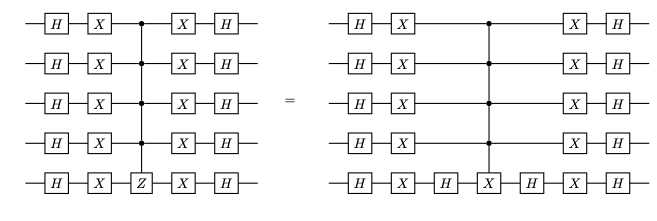

The hadamard gates will create a superposition of all states. Then, the X gate performs a qubit-flip (equivalent to the NOT classical gate) so it conducts a rotation by π radians around the x-axis of the Bloch sphere. When we have the states flipped...

In [8]:
def diffusion(q0,nqubits): 

    c.add([gates.H(i) for i in range(nqubits)])     
    c.add([gates.X(i) for i in range(nqubits)])   
    MCZ(q0,nqubits) #q0 is the target and the other ones, control qubits
    c.add([gates.X(i) for i in range(nqubits)])
    c.add([gates.H(i) for i in range(nqubits)])
    
    return c

## Main code: Grover's algorithm 

The purpose of the program is to find a state that will be asked as an input. In this section we will apply the Grover's algorithm for $n qubits$ = 3 qubits and show that the probability to find the one we want is the highest among all the possibilities. 
Moreover, we will plot an histogram showing probabilities of states and we will show how the maximum probability increases as we apply the Grover's iterator more times. 

### Grover's algorithm for 3 qubits

The code follows the next procedure to find the state: 
    
1. Asks the number of qubits of the circuit and the state you want to find. 
2. Calculates R corresponding to repetitions of the Grover's iterator. The more times we apply the oracle, the higher probability we will get. (demonstration of the following equation) 
<br>

<center> $R = \frac{\pi}{4}\cdot \sqrt{N}$ </center>

<br>

3. Starts a loop running the full Grover's algorithm for each R: 
- Creates the circuit 
- Applies Hadamard gates for superposition
- Applies the Grover's iterator
- Executes the circuit in order to find the result 
- Adds the maximum probability corresponding to the state we want to a list that will be plotted    
    
4. Draws the circuit. 

In [9]:
nqubits = int(input("How many qubits does the circuit have? "))
state = int(input("Which state do you want to find? "))
probs = [ ] #probabilities of the target
print()

R = int((np.pi/4)*np.sqrt(2**nqubits))
print("Number of times we apply the oracle = ", R)
print()

for k in range(1,R+1):
    c = Circuit(nqubits) # Construct the circuit (2 qubits)
    c.add([gates.H(i) for i in range(nqubits)])
    for j in range(k):
        # Rotation of the state we are searching for
        oracle_general(nqubits,state) 
        diffusion(0,nqubits)
         
   # Execute the circuit and obtain the final state
    result = c()
    y = result.state(numpy=True)
    probs.append(max([x.real*x.real for x in y]))

# Draw the circuit
print(c.draw())

How many qubits does the circuit have? 3
Which state do you want to find? 7

Number of times we apply the oracle =  2

q0: ─H─o─H─X───o─X─H───o─H─X───o─X─H───
q1: ─H─o─H─X───o─X─H───o─H─X───o─X─H───
q2: ─H─Z─H─X─H─X─H─X─H─Z─H─X─H─X─H─X─H─


### Plots

These plots will show, from all states available (created by nqubits), the one with more probability which corresponds to the one we were searching for, and how this probability increases as we apply more times Grover's iterator. 

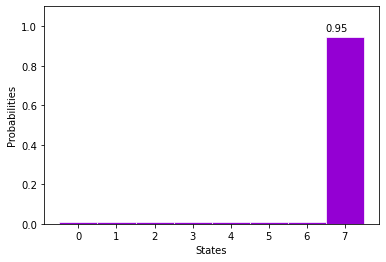

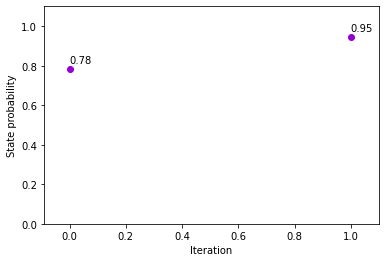

In [10]:
# FINDING STATE 
x = range(2**nqubits) 
y = result.state(numpy=True)

prob = [x.real*x.real for x in y] # elevating coeficients = probability 

fig, ax = plt.subplots()

ax.bar(x, prob, width=1, edgecolor="white",color = "darkviolet", linewidth=0.7)
ax.set(ylim=(0, 1.1), xlabel = 'States', ylabel = 'Probabilities')

ax.text(prob.index(max(prob))-0.5,max(prob)+0.03, str(round(max(prob),2)), fontsize=10)
plt.savefig("Grover_nqubits.eps") 
plt.show()

# MAX. PROBABILIY 
oracle_times = range(R) 
plt.plot(oracle_times, probs,'o', color = "darkviolet")
plt.xlim([0 -0.09 ,R -0.9])
plt.ylim([0,1.1])
plt.xlabel('Iteration')
plt.ylabel('State probability') 

i=0 #writes the probability of each state 
for el in probs:
    plt.text(oracle_times[i],el+0.03, str(round(el.real, 2)), fontsize=10)
    i=i+1
plt.savefig("prob_nqubits.eps")  
plt.show()

## Scan with n=2,...,8 qubits

To compare the performance of the classical method and the quantum one, we will try to find the state 3 changing the number of qubits of the circuit from 2 to 9. We will calculate the time for each iteration and the times we apply the oracle to find the state. 

### Quantum algorithm (Grover's)

Firstly, we will apply the Grover's algorithm (quantum method), using a loop in order to change the number of qubits from 2 to 9. 

In [11]:
state = int(input("Which state do you want to find? "))
probability = [ ]
q_oracle = [ ]
print()

for nqubits in range(2,9):

    c = Circuit(nqubits) # Construct the circuit (2 qubits)
    c.add([gates.H(i) for i in range(nqubits)])

    R = int((np.pi/4)*np.sqrt(2**nqubits)) #time we apply the oracle 
    
    for i in range(1,R+1):
        # Rotation of the state we are searching for 
        oracle_general(nqubits,state) 
        diffusion(0,nqubits)
    
    # Execute the circuit and obtain the final state
    result = c() 
    y = result.state(numpy=True)
    probability.append(max([x*x.conjugate() for x in y]))
    q_oracle.append(R)

Which state do you want to find? 2



### Classical algorithm

We know that Grover's algorithm reduces the time needed to find the state and that the result converges as $\sqrt N$ with $N = 2^{nqubits}$, so we can use the previous section to compare it with the performation of the classical method to find an element of a list. DE MOMENT NO. 

We should see that the classical method escalates as $N$, much slower than the quantum performance. 
- We will create a list corresponding to all states available 
- A loop (equivalent to the oracle) will search element by element from the list until it finds the state we wanted
- At the begining we will initiate a counter in order to know how many elements of the list the code has checked to know if the state was in that position

In [12]:
c_oracle = [ ]
for nqubits in range(2,9):
    states_list = list(range(2**nqubits))
    np.random.shuffle(states_list)
    
    i=0
    for el in states_list:
        if el == state:
            c_oracle.append(i)
        i +=1

### Plot comparision 

Here we present a plot that represents the times we apply the oracle versus the number of qubits, using the classical and quantum algorithm. We can, indeed, see how the number of times we apply the oracle converges as N classically, and as $\sqrt N$ when we use Grover's algorithm. 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


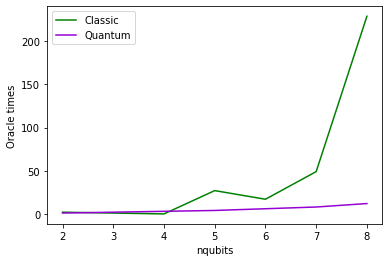

In [13]:
x = range(2,9) #nqubits list 
# oracle times vs nqubits
plt.plot(x,c_oracle, label = "Classic", color = "green")
plt.plot(x,q_oracle, label = "Quantum", color = "darkviolet")
plt.xlabel("nqubits")
plt.ylabel("Oracle times")
plt.legend()
plt.savefig("classicvsquant.eps") 
plt.show()